In [3]:
!pip install -e /dss/dsshome1/04/di93zer/git/cellnet --no-deps

Obtaining file:///dss/dsshome1/04/di93zer/git/cellnet
  Preparing metadata (setup.py) ... done
  Running setup.py develop for cellnet

[notice] A new release of pip is available: 23.1.1 -> 23.2.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
!pip install celltypist

In [1]:
import os
import re
import gc
from os.path import join

import anndata
import numpy as np
import pandas as pd
import xgboost as xgb
import dask.dataframe as dd
import pandas as pd
import lightning.pytorch as pl
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix
from sklearn.metrics import classification_report
from cellnet.estimators import EstimatorCellTypeClassifier
from cellnet.models import TabnetClassifier, LinearClassifier, MLPClassifier
from utils import correct_labels, get_best_ckpts, macro_f1_per_group, BIONETWORK_GROUPING

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.8/dist-packages/merlin/dtypes/mappings/tf.py:52: UserWarning: Tensorflow dtype mappings did not load successfully due to an error: No module named 'tensorflow'
  warn(f"Tensorflow dtype mappings did not load successfully due to an error: {exc.msg}")


In [2]:
def get_count_matrix(ddf):
    x = (
        ddf['X']
        .map_partitions(
            lambda xx: pd.DataFrame(np.vstack(xx.tolist())), 
            meta={col: 'f4' for col in range(19331)}
        )
        .to_dask_array(lengths=[1024] * ddf.npartitions)
    )
    
    return x


In [3]:
def eval_tabnet(ckpts, data_path):
    estim = EstimatorCellTypeClassifier(data_path)
    estim.init_datamodule(batch_size=2048)
    estim.trainer = pl.Trainer(logger=[], accelerator='gpu', devices=1)

    preds = []
    for ckpt in ckpts:
        estim.model = TabnetClassifier.load_from_checkpoint(ckpt, **estim.get_fixed_model_params('tabnet'))
        probas = estim.predict(estim.datamodule.test_dataloader())
        preds.append(np.argmax(probas, axis=1))
        gc.collect()

    return preds


def eval_linear(ckpts, data_path):
    estim = EstimatorCellTypeClassifier(data_path)
    estim.init_datamodule(batch_size=2048)
    estim.trainer = pl.Trainer(logger=[], accelerator='gpu', devices=1)

    preds = []
    for ckpt in ckpts:
        estim.model = LinearClassifier.load_from_checkpoint(ckpt, **estim.get_fixed_model_params('linear'))
        probas = estim.predict(estim.datamodule.test_dataloader())
        preds.append(np.argmax(probas, axis=1))
        gc.collect()

    return preds


def eval_xgboost(ckpts, data_path):
    x_test = np.load(join(data_path, 'pca/x_pca_training_test_split_256.npy'))
    
    preds = []
    for ckpt in ckpts:
        clf = xgb.XGBClassifier()
        clf.load_model(ckpt)
        clf.set_params(predictor='gpu_predictor')
        preds.append(clf.predict(x_test))

    return preds


def eval_mlp(ckpts, data_path):
    estim = EstimatorCellTypeClassifier(data_path)
    estim.init_datamodule(batch_size=2048)
    estim.trainer = pl.Trainer(logger=[], accelerator='gpu', devices=1)

    preds = []
    for ckpt in ckpts:
        estim.model = MLPClassifier.load_from_checkpoint(ckpt, **estim.get_fixed_model_params('mlp'))
        probas = estim.predict(estim.datamodule.test_dataloader())
        preds.append(np.argmax(probas, axis=1))
        gc.collect()

    return preds


def eval_celltypist(ckpts, data_path):
    import celltypist
    
    ddf = dd.read_parquet(join(data_path, 'test'), split_row_groups=True)
    x = get_count_matrix(ddf)
    var = pd.read_parquet(join(data_path, 'var.parquet'))

    preds = []
    for ckpt in ckpts:
        preds_ckpt = []
        # run this in batches to keep the memory footprint in check
        for i, idxs in enumerate(np.array_split(np.arange(x.shape[0]), 20)):
            # data is already normalized
            adata_test = anndata.AnnData(
                X=x[idxs, :].map_blocks(csr_matrix).compute(), 
                var=var.set_index('feature_name')
            )
            preds_ckpt.append(celltypist.annotate(adata_test, model=ckpt))

        preds.append(
            np.concatenate([batch.predicted_labels.to_numpy().flatten() for batch in preds_ckpt])
        )

    return preds


# Evaluate performance

In [4]:
DATA_PATH = '/mnt/dssmcmlfs01/merlin_cxg_2023_05_15_sf-log1p'

LOGS_TABNET = '/mnt/dssfs02/tb_logs/cxg_2023_05_15_tabnet/default'
LOGS_LINEAR = '/mnt/dssfs02/tb_logs/juwles/cxg_2023_05_15_linear/default'
LOGS_XGBOOST = '/mnt/dssfs02/tb_logs/cxg_2023_05_15_xgboost'
LOGS_MLP = '/mnt/dssfs02/tb_logs/cxg_2023_05_15_mlp/default'
LOGS_CELLTYPIST = '/mnt/dssfs02/tb_logs/cxg_2023_05_15_celltypist'


CKPTS = {
    'xgboost': [join(LOGS_XGBOOST, f'version_20_{i}.json') for i in range(1, 6)],
    'xgboost_default': [join(LOGS_XGBOOST, f'default_params_{i}.json') for i in range(1, 5)],
    'tabnet': get_best_ckpts(LOGS_TABNET, [f'w_augment_{i}' for i in range(1, 6)]),
    'linear': get_best_ckpts(LOGS_LINEAR, [f'version_{i}' for i in range(1, 5)]),
    'MLP': get_best_ckpts(LOGS_MLP, [f'version_{i}' for i in range(3, 8)]),
    'celltypist': [join(LOGS_CELLTYPIST, f'model_1500000_cells_run{i}.pkl') for i in range(1, 5)],
    'celltypist_default': [join(LOGS_CELLTYPIST, f'model_1000000_cells_with_mean_run{i}.pkl') for i in range(1, 5)]
}

In [5]:
cell_type_hierarchy = np.load(join(DATA_PATH, 'cell_type_hierarchy/child_matrix.npy'))
y_true = dd.read_parquet(join(DATA_PATH, 'test'), columns='cell_type').compute().to_numpy()
tissue_general_mapping = pd.read_parquet(join(DATA_PATH, 'categorical_lookup/tissue_general.parquet'))
tissue_general = dd.read_parquet(join(DATA_PATH, 'test'), columns='tissue_general').compute().to_numpy()

## Overall

In [6]:
res = pd.read_csv('model_comparision.csv', index_col=0)

In [7]:
results = {'f1-score (macro avg.)': [], 'model': [], 'run': []}


for model, ckpts in CKPTS.items():
    if model not in res.model.tolist():
        if model == 'tabnet':
            preds = eval_tabnet(ckpts, DATA_PATH)
        elif model == 'linear':
            preds = eval_linear(ckpts, DATA_PATH)
        elif model == 'xgboost':
            preds = eval_xgboost(ckpts, DATA_PATH)
        elif model == 'xgboost_default':
            preds = eval_xgboost(ckpts, DATA_PATH)
        elif model == 'MLP':
            preds = eval_mlp(ckpts, DATA_PATH)
        elif model == 'celltypist':
            preds = eval_celltypist(ckpts, DATA_PATH)
        elif model == 'celltypist_default':
            preds = eval_celltypist(ckpts, DATA_PATH)
        else:
            raise ValueError

        for run, y_pred in enumerate(preds):
            y_pred_corr = correct_labels(y_true, y_pred, cell_type_hierarchy)
            clf_report = pd.DataFrame(classification_report(y_true, y_pred_corr, output_dict=True)).T
            results['f1-score (macro avg.)'].append(clf_report.loc['macro avg', 'f1-score'])
            results['model'].append(model)
            results['run'].append(f'{model}_run{run}')


In [8]:
res = pd.concat([res, pd.DataFrame(results)]).reset_index(drop=True)

In [ ]:
res.to_csv('model_comparision.csv')

In [13]:
(
    res
    .groupby('model')['f1-score (macro avg.)']
    .aggregate(['mean', 'std'])
    .applymap("{0:.4f}".format)
)

,mean,std
model,,
MLP,0.7971,0.0012
celltypist,0.7304,0.0015
celltypist_default,0.6258,0.0036
linear,0.7848,0.0001
tabnet,0.8295,0.0007
xgboost,0.8127,0.0005
xgboost_default,0.5855,0.0112


In [19]:
(
    res[res.model.isin(['linear', 'tabnet'])]
    .groupby('model')['f1-score (macro avg.)']
    .aggregate(['mean', 'var'])
    .applymap("{0:.8f}".format)
)

,mean,var
model,,
linear,0.78483384,0.00000002
tabnet,0.82949732,0.00000055


In [21]:
f'{0.82949732 - 0.78483384:.4f}±{(0.00000055 + 0.00000002)**0.5:.4f}'

'0.0447±0.0008'

# Plot model comparision

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
model_comparision_df = pd.read_csv('model_comparision.csv', index_col=0)
model_comparision_df[~model_comparision_df.model.isin(['xgboost_default', 'celltypist_default'])]
model_comparision_df.sample(5)

,f1-score (macro avg.),model,run
2,0.812918,xgboost,xgboost_run2
28,0.627432,celltypist_default,celltypist_default_run1
0,0.812979,xgboost,xgboost_run0
13,0.784686,linear,linear_run3
1,0.813049,xgboost,xgboost_run1


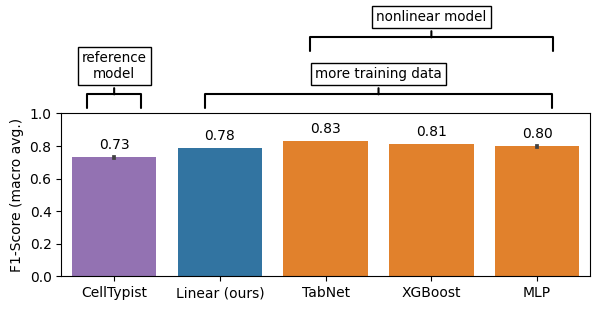

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(6.1, 4))

ax = sns.barplot(
    x='model',
    y='f1-score (macro avg.)',
    order=['celltypist', 'linear', 'tabnet', 'xgboost', 'MLP'],
    errorbar='sd',
    palette=['#9467bd', '#1f77b4', '#ff7f0e', '#ff7f0e', '#ff7f0e'],
    data=model_comparision_df
)
ax.set_ylabel('F1-Score (macro avg.)')
ax.set_xlabel('')
ax.set_xticklabels(['CellTypist', 'Linear (ours)', 'TabNet', 'XGBoost', 'MLP'])
ax.set_ylim(0., 1.)


for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')


fs = 6.5
ax.annotate('nonlinear model', xy=(0.7, 1.45), xytext=(0.7, 1.55), xycoords='axes fraction', 
            fontsize=fs*1.5, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white', color='k'),
            arrowprops=dict(arrowstyle='-[, widthB=9., lengthB=1.', lw=1.5, color='k'))

ax.annotate('more training data', xy=(0.6, 1.1), xytext=(0.6, 1.2), xycoords='axes fraction', 
            fontsize=fs*1.5, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white', color='k'),
            arrowprops=dict(arrowstyle='-[, widthB=12.8, lengthB=1.', lw=1.5, color='k'))

ax.annotate('reference\nmodel', xy=(0.1, 1.1), xytext=(0.1, 1.2), xycoords='axes fraction', 
            fontsize=fs*1.5, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white', color='k'),
            arrowprops=dict(arrowstyle='-[, widthB=2., lengthB=1.', lw=1.5, color='k'))

plt.tight_layout()
plt.savefig('/dss/dsshome1/04/di93zer/git/cellnet/figure-plots/figure1/model-comparision.pdf')
plt.savefig('/dss/dsshome1/04/di93zer/git/cellnet/figure-plots/figure1/model-comparision.png', dpi=300)

## Grouped by bionetwork

In [56]:
# only do this for TabNet + Linear model for now

In [ ]:
preds_tabnet = eval_tabnet(
    get_best_ckpts(LOGS_TABNET, [f'w_augment_{i}' for i in range(1, 6)]), DATA_PATH
)

In [ ]:
preds_linear = eval_linear(
    get_best_ckpts(LOGS_LINEAR, [f'version_{i}' for i in range(1, 5)]), DATA_PATH
)

In [53]:
tissue = tissue_general_mapping.loc[tissue_general].to_numpy().flatten()
res = {'f1-score (macro avg.)': [], 'bionetwork': [], 'run': [], 'model': []}


for model, preds in [('TabNet', preds_tabnet), ('Linear', preds_linear)]:
    for i, y_pred in enumerate(preds):
        y_pred_corr = correct_labels(y_true, y_pred, cell_type_hierarchy)
        f1_score_per_bionetwork = macro_f1_per_group(y_true, y_pred, tissue, BIONETWORK_GROUPING)
        res['f1-score (macro avg.)'] += f1_score_per_bionetwork.f1_score.tolist()
        res['bionetwork'] += f1_score_per_bionetwork.group.tolist()
        res['run'] += [f'run{i}'] * len(f1_score_per_bionetwork)
        res['model'] += [model] * len(f1_score_per_bionetwork)
        gc.collect()


In [54]:
df = pd.DataFrame(res)
df.to_csv('linear_vs_tabnet_per_organ.csv')

In [30]:
shortend_bionetworks = {
    'oral and craniofacial': 'craniofacial\noral',
    'blood and immune': 'blood\nimmune',
    'nervous system': 'nervous\nsystem',
    'musculoskeletal': 'musculo\nskeletal',
}

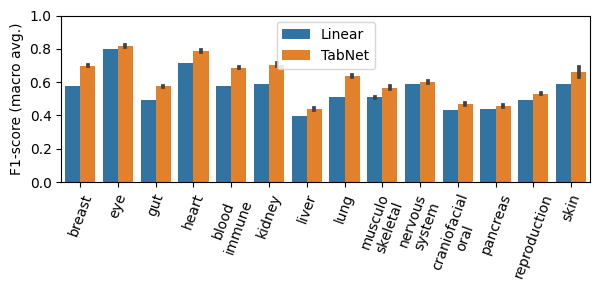

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(6.1, 3.))

df = pd.read_csv('linear_vs_tabnet_per_organ.csv', index_col=0)
df['bionetwork'] = (
    df['bionetwork']
    .str.replace('_', ' ')
    .replace(shortend_bionetworks)
)
ax = sns.barplot(
    x='bionetwork',
    y='f1-score (macro avg.)',
    hue='model',
    hue_order=['Linear', 'TabNet'],
    data=df[df.bionetwork != 'adipose'],
    ax=ax,
)
ax.set_xlabel('')
ax.set_ylabel('F1-score (macro avg.)')
ax.tick_params(axis='x', labelrotation=70)
ax.legend(title='')
ax.set_ylim(0., 1.)

plt.tight_layout()
plt.savefig('/dss/dsshome1/04/di93zer/git/cellnet/figure-plots/figure1/organ_wise_performance.pdf')
plt.savefig('/dss/dsshome1/04/di93zer/git/cellnet/figure-plots/figure1/organ_wise_performance.png', dpi=300)

# Lung only vs cross organ model

In [4]:
from statistics import mean, stdev
from scipy.stats import ttest_ind

In [5]:
DATA_PATH = '/mnt/dssmcmlfs01/merlin_cxg_2023_05_15_sf-log1p_lung_only'

In [6]:
cell_type_hierarchy = np.load(join(DATA_PATH, 'cell_type_hierarchy/child_matrix.npy'))
y_true = dd.read_parquet(join(DATA_PATH, 'test'), columns='cell_type').compute().to_numpy()
tissue_general_mapping = pd.read_parquet(join(DATA_PATH, 'categorical_lookup/tissue_general.parquet'))
tissue_general = dd.read_parquet(join(DATA_PATH, 'test'), columns='tissue_general').compute().to_numpy()

In [7]:
LOGS_CROSS_ORGAN = '/mnt/dssfs02/tb_logs/cxg_2023_05_15_tabnet/default'
LOGS_LUNG_ONLY = '/mnt/dssfs02/tb_logs/cxg_2023_05_15_lung_only_tabnet/default'
LOGS_CROSS_ORGAN_LINEAR = '/mnt/dssfs02/tb_logs/cxg_2023_05_15_linear/default'
LOGS_LUNG_ONLY_LINEAR = '/mnt/dssfs02/tb_logs/cxg_2023_05_15_lung_only_linear/default'

ckpts_cross_organ = get_best_ckpts(LOGS_CROSS_ORGAN, [f'no_augment_{i}' for i in range(1, 6)])
ckpts_lung_only = get_best_ckpts(LOGS_LUNG_ONLY, [f'no_augment_{i}' for i in range(1, 6)])
ckpts_cross_organ_linear = get_best_ckpts(LOGS_CROSS_ORGAN_LINEAR, [f'version_{i}' for i in range(1, 5)])
ckpts_lung_only_linear = get_best_ckpts(LOGS_LUNG_ONLY_LINEAR, [f'version_{i}' for i in range(1, 6)])

In [ ]:
preds_cross_organ = eval_tabnet(ckpts_cross_organ, DATA_PATH)

In [ ]:
preds_cross_organ_linear = eval_linear(ckpts_cross_organ_linear, DATA_PATH)

In [ ]:
preds_lung_only = eval_tabnet(ckpts_lung_only, DATA_PATH)

In [ ]:
preds_lung_only_linear = eval_linear(ckpts_lung_only_linear, DATA_PATH)

In [12]:
f1_scores_cross_organ = []

for y_pred in preds_cross_organ:
    y_pred_corr = correct_labels(y_true, y_pred, cell_type_hierarchy)
    f1_scores_cross_organ.append(
        float(pd.DataFrame(classification_report(
            y_true, 
            y_pred_corr, 
            labels=np.unique(y_true),
            zero_division=0.,
            output_dict=True
        )).T.loc['macro avg', 'f1-score'])
    )

print(f'{mean(f1_scores_cross_organ):.4f} +/- {stdev(f1_scores_cross_organ):.4f}')

0.7062 +/- 0.0122


In [13]:
f1_scores_cross_organ_linear = []

for y_pred in preds_cross_organ_linear:
    y_pred_corr = correct_labels(y_true, y_pred, cell_type_hierarchy)
    f1_scores_cross_organ_linear.append(
        float(pd.DataFrame(classification_report(
            y_true, 
            y_pred_corr, 
            labels=np.unique(y_true),
            zero_division=0.,
            output_dict=True
        )).T.loc['macro avg', 'f1-score'])
    )

print(f'{mean(f1_scores_cross_organ_linear):.4f} +/- {stdev(f1_scores_cross_organ_linear):.4f}')

0.5291 +/- 0.0041


In [14]:
f1_scores_lung_only = []

for y_pred in preds_lung_only:
    y_pred_corr = correct_labels(y_true, y_pred, cell_type_hierarchy)
    f1_scores_lung_only.append(
        float(pd.DataFrame(classification_report(
            y_true, 
            y_pred_corr, 
            labels=np.unique(y_true),
            zero_division=0.,
            output_dict=True
        )).T.loc['macro avg', 'f1-score'])
    )

print(f'{mean(f1_scores_lung_only):.4f} +/- {stdev(f1_scores_lung_only):.4f}')

0.7220 +/- 0.0078


In [15]:
f1_scores_lung_only_linear = []

for y_pred in preds_lung_only_linear:
    y_pred_corr = correct_labels(y_true, y_pred, cell_type_hierarchy)
    f1_scores_lung_only_linear.append(
        float(pd.DataFrame(classification_report(
            y_true, 
            y_pred_corr, 
            labels=np.unique(y_true),
            zero_division=0.,
            output_dict=True
        )).T.loc['macro avg', 'f1-score'])
    )

print(f'{mean(f1_scores_lung_only_linear):.4f} +/- {stdev(f1_scores_lung_only_linear):.4f}')

0.7146 +/- 0.0040


In [16]:
print(f'p-value: {ttest_ind(f1_scores_lung_only, f1_scores_cross_organ).pvalue:.4f}')

p-value: 0.0403


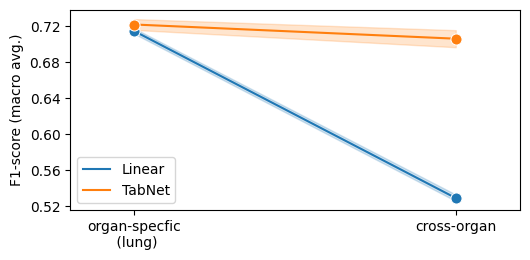

In [21]:
df_cross_organ_vs_lung = pd.DataFrame({
    'F1-score (macro avg.)': (
        f1_scores_cross_organ + 
        f1_scores_lung_only + 
        f1_scores_cross_organ_linear + 
        f1_scores_lung_only_linear
    ),
    'training': (
        ['cross-organ'] * len(f1_scores_cross_organ) + 
        ['organ-specfic\n (lung)'] * len(f1_scores_lung_only) +
        ['cross-organ'] * len(f1_scores_cross_organ_linear) + 
        ['organ-specfic\n (lung)'] * len(f1_scores_lung_only_linear)
    ),
    'model': (
        ['TabNet'] * len(f1_scores_cross_organ) + 
        ['TabNet'] * len(f1_scores_lung_only) +
        ['Linear'] * len(f1_scores_cross_organ_linear) + 
        ['Linear'] * len(f1_scores_lung_only_linear)
    )
}).sort_values('training', ascending=False)


fig, ax = plt.subplots(1, 1, figsize=[5.4, 2.7])
sns.lineplot(
    x='training',
    y='F1-score (macro avg.)',
    hue='model',
    hue_order=['Linear', 'TabNet'],
    data=df_cross_organ_vs_lung,
    marker='o',
    markersize=8,
    sort=False,
    ax=ax
)
# ax.set_ylim(0.4, 0.9)
ax.set_xlim([-0.2, 1.2])
ax.set_xlabel('')
ax.set_yticks(np.linspace(0.52, 0.72, 6))
ax.legend(title='')

plt.tight_layout()
plt.savefig('/dss/dsshome1/04/di93zer/git/cellnet/figure-plots/figure2/cross_organ_vs_lung_only.pdf')
plt.savefig('/dss/dsshome1/04/di93zer/git/cellnet/figure-plots/figure2/cross_organ_vs_lung_only.png', dpi=300)